# Polynomial fits and roots

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Make a curve to be modeled by a polynomial.

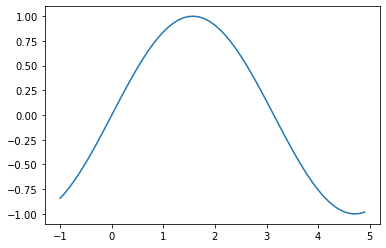

In [3]:
t = np.arange(-1, 5, 0.1)
y = np.sin(t)
fig, ax = plt.subplots()
ax.plot(t, y)

## Old polynomial API

https://numpy.org/doc/stable/reference/routines.polynomials.poly1d.html

The coefficients are ordered from highest power to lowest.

Coefficients:  [ 0.02538711 -0.16149973 -0.06142091  1.00375468  0.02009165]
All roots:  [ 5.48262591  3.17373207 -2.27487962 -0.01999332]
Roots in original domain:  [3.1737320687929205, -0.01999332168465538]


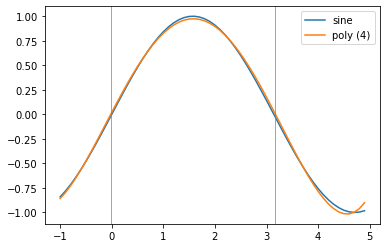

In [4]:
order = 4
p = np.polyfit(t, y, order)
print("Coefficients: ", p)
yp = np.polyval(p, t)
r = np.roots(p)
print("All roots: ", r)
r = [root for root in r if t[0] < root < t[-1]]
print("Roots in original domain: ", r)
fig, ax = plt.subplots()
ax.plot(t, y, label="sine")
ax.plot(t, yp, label=f"poly ({order})")
ax.legend()
for root in r:
    ax.axvline(root, color="0.5", lw=0.7)

## New polynomial API

https://numpy.org/doc/stable/reference/routines.polynomials.html

Coefficients are ordered from lowest power to highest.

This API is more powerful but more complicated, and the documentation is somewhat scattered.

In [5]:
from numpy.polynomial import Polynomial as P

0.9134323433943667 - 0.959121781598798·x¹ - 3.7158577600178924·x² +
0.937548479846201·x³ + 1.9226550143321506·x⁴
Coefficients:  [ 0.91343234 -0.95912178 -3.71585776  0.93754848  1.92265501]
Converted back to original (unscaled) x:  0.02009164748009018 + 1.0037546835810833·x¹ - 0.061420910318852606·x² -
0.16149973376208887·x³ + 0.02538711211897908·x⁴
Converted coefficients:  [ 0.02009165  1.00375468 -0.06142091 -0.16149973  0.02538711]
Domain:  [-1.   4.9]
All roots:  [-2.27487962 -0.01999332  3.17373207  5.48262591]
Roots in original domain:  [-0.01999332168465129, 3.173732068792912]


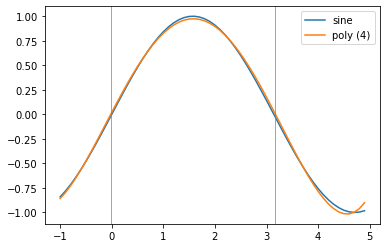

In [6]:
order = 4
pnew = P.fit(t, y, order)
print(pnew)
print("Coefficients: ", pnew.coef)
print("Converted back to original (unscaled) x: ", pnew.convert())
print("Converted coefficients: ", pnew.convert().coef)
print("Domain: ", pnew.domain)
print("All roots: ", pnew.roots())
rnew = [root for root in pnew.roots() if t[0] < root < t[-1]]
print("Roots in original domain: ", rnew)
ypnew = pnew(t)
fig, ax = plt.subplots()
ax.plot(t, y, label="sine")
ax.plot(t, ypnew, label=f"poly ({order})")
ax.legend()
for root in rnew:
    ax.axvline(root, color="0.5", lw=0.7)

## Starting from xarray

At this writing, xarray has `polyval` and `polyfit` functions from the old API, but is missing the `roots` function, so we need to go straight to numpy for that.

For illustration, we will convert `t` as days from the start of 2022 to datetime64 and then combine it with `y` in a Dataset.

In [7]:
dt64 = np.datetime64("2022-01-01") + (t * 86400).astype("timedelta64[s]")
ds = xr.Dataset({"y": (["time"], y)}, coords={"time": dt64})

In [8]:
print(dt64[:3])

['2021-12-31T00:00:00' '2021-12-31T02:24:00' '2021-12-31T04:48:00']


In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 60)
Coordinates:
  * time     (time) datetime64[ns] 2021-12-31 ... 2022-01-05T21:35:59
Data variables:
    y        (time) float64 -0.8415 -0.7833 -0.7174 ... -0.9999 -0.9962 -0.9825

Notice that xarray is converting our dt64 in seconds to use nanoseconds, which means it cannot be used for applications involving years before 1678.

In [10]:
xpoly = ds.polyfit("time", 4)

/Users/efiring/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/nputils.py:276: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, lhs.shape[1])


I think that warning is because the old API is working directly with time in nanoseconds since the unix epoch, which is very bad from a numeric standpoint.

In [11]:
 xpoly

<xarray.Dataset>
Dimensions:                 (degree: 5)
Coordinates:
  * degree                  (degree) int64 4 3 2 1 0
Data variables:
    y_polyfit_coefficients  (degree) float64 1.725e-62 -5.663e-44 ... -1.252e+11

We can get the fit from an xarray function, and then go to numpy for the roots.

In [12]:
xfit = xr.polyval(ds.time, xpoly)
rx = np.roots(xpoly.y_polyfit_coefficients.values)
print("Raw roots: ", rx)
rx_dt64 = np.datetime64("1970-01-01") + rx.astype("timedelta64[ns]")
print("As dt64: ", rx_dt64)
rx_dt64_trimmed = rx_dt64[(dt64[0] < rx_dt64) & (rx_dt64 < dt64[-1])]
print("In the domain: ", rx_dt64_trimmed)

Raw roots:  [-1.64121394e+18  1.64178433e+18  1.64127653e+18  1.64097759e+18]
As dt64:  ['1917-12-29T11:14:18.231899904' '2022-01-10T03:12:09.191722752'
 '2022-01-04T06:08:52.188073728' '2021-12-31T19:06:25.144052736']
In the domain:  ['2022-01-04T06:08:52.188073728' '2021-12-31T19:06:25.144052736']


We can convert those datetime64 roots back to days for comparison to the earlier calculations, done with more reasonable numerics.

In [13]:
ns_per_day = 86400 * 1e9
rx_days = (rx_dt64_trimmed - np.datetime64("2022-01-01")).astype(float) / ns_per_day
print("Roots in the domain")
print("Bad numerics with nanoseconds: ", sorted(rx_days))
print("Good numerics (Polynomial):    ", sorted(rnew))
print("Good enough (old API):         ", sorted(r))

Roots in the domain
Bad numerics with nanoseconds:  [-0.2038756475377778, 3.256159584186667]
Good numerics (Polynomial):     [-0.01999332168465129, 3.173732068792912]
Good enough (old API):          [-0.01999332168465538, 3.1737320687929205]


Conclusion: if you are doing a polynomial (or other) fit against a time variable in datetime64, don't use xarray for that calculation. Pull your variables out as numpy arrays, shift and scale as needed, and do your calculations with numpy functions.

Continuing with this example:

In [14]:
dt64_1 = ds.time.values
t_1 = (dt64_1 - np.datetime64("2022-01-01")).astype(float) / ns_per_day
y_1 = ds.y.values

Now you can proceed with either the old or the new API.

In [15]:
# old
p_1 = np.polyfit(t_1, y_1, order)
roots_1 = np.roots(p_1)

# new
p_2 = P.fit(t_1, y_1, order)
roots_2 = p_2.roots()

print("Old API: ", sorted(roots_1)[1:-1])
print("New API: ", sorted(roots_2)[1:-1])

Old API:  [-0.019999439760897762, 3.1737205425158708]
New API:  [-0.01999943976089802, 3.17372054251587]


If you want to look at the fit to the original times, you can still do it easily by calculating the fit in numpy (so it's accurate) and then putting it into your original (or another) xarray.

In [16]:
# old API

fit_1 = np.polyval(p_1, t_1)
ds2 = ds.copy()
ds2["y_fit"] = (["time"], fit_1)
ds2["residual"] = ds2["y"] - ds2["y_fit"]
ds2

<xarray.Dataset>
Dimensions:   (time: 60)
Coordinates:
  * time      (time) datetime64[ns] 2021-12-31 ... 2022-01-05T21:35:59
Data variables:
    y         (time) float64 -0.8415 -0.7833 -0.7174 ... -0.9999 -0.9962 -0.9825
    y_fit     (time) float64 -0.8582 -0.7987 -0.7291 ... -0.9983 -0.9611 -0.9013
    residual  (time) float64 0.01673 0.01532 0.01178 ... -0.0351 -0.08111